In [27]:
import numpy as np
import sympy as s
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import Math
from matplotlib.patches import FancyArrowPatch as fArrow
from matplotlib.path import Path

## Resources

* Drivetrain Hub :: Geometry/Involute :: Chad Glinsky
    * https://www.drivetrainhub.com/notebooks/gears/geometry/Chapter%201%20-%20Involute.html
    * Description of Involute and its Basic Construction

## Utils 

In [28]:
# Pi-based Graphing Helper for MatPlotLib
# https://stackoverflow.com/questions/40642061/how-to-set-axis-ticks-in-multiples-of-pi-python-matplotlib 
def multiple_formatter(denominator=2, number=np.pi, latex='\\pi'):
    def gcd(a, b):
        while b:
            a, b = b, a%b
        return a
    def _multiple_formatter(x, pos):
        den = denominator
        num = int(np.rint(den*x/number))
        com = gcd(num,den)
        (num,den) = (int(num/com),int(den/com))
        if den==1:
            if num==0:
                return r'$0$'
            if num==1:
                return r'$%s$'%latex
            elif num==-1:
                return r'$-%s$'%latex
            else:
                return r'$%s%s$'%(num,latex)
        else:
            if num==1:
                return r'$\frac{%s}{%s}$'%(latex,den)
            elif num==-1:
                return r'$\frac{-%s}{%s}$'%(latex,den)
            else:
                return r'$\frac{%s%s}{%s}$'%(num,latex,den)
    return _multiple_formatter

class Multiple:
    def __init__(self, denominator=2, number=np.pi, latex='\\pi'):
        self.denominator = denominator
        self.number = number
        self.latex = latex

    def locator(self):
        return plt.MultipleLocator(self.number / self.denominator)

    def formatter(self):
        return plt.FuncFormatter(multiple_formatter(self.denominator, self.number, self.latex))

def addPiSpacing(gca, spacing = (2,2), axisDir = "both"):
    gca.grid(True)
    #gca.set_aspect(1.0)
    gca.axhline(0, color='black', lw=2)
    gca.axvline(0, color='black', lw=2)
    if ( (axisDir == "x") | (axisDir =="both") ):
        gca.xaxis.set_major_locator(plt.MultipleLocator(np.pi / spacing[0]))
        gca.xaxis.set_minor_locator(plt.MultipleLocator(np.pi / (spacing[0] * 4)))
        gca.xaxis.set_major_formatter(plt.FuncFormatter(multiple_formatter(denominator=spacing[0])))
    if ( (axisDir == "y") | (axisDir =="both") ):
        gca.yaxis.set_major_locator(plt.MultipleLocator(np.pi / spacing[1]))
        gca.yaxis.set_minor_locator(plt.MultipleLocator(np.pi / (spacing[1] * 4)))
        gca.yaxis.set_major_formatter(plt.FuncFormatter(multiple_formatter(denominator=spacing[1])))
    plt.show()

# The Involute Function

The involute is a geometric curve of various unique properties, on one hand one of the ideal forms for so-called 'conjugate action' power transmission (**gears**) but also being rather unweildy to work with (e.g. only algebraically solveable in ONE direction).

The curve itself may be described in two ways: parametrically or by tangents.

## Parametric Solution

The parametric form lends itself to plotting. The x and y components are effectively inverse components to this curve defined by both the travel around the base circle (in blue) and the circumferential length traveled along this base circle already  -- multiplying the other component by the current arc length ($\phi$) travelled.

<IPython.core.display.Math object>

<IPython.core.display.Math object>

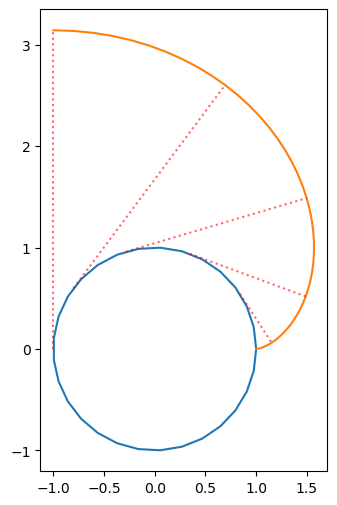

In [29]:
x, y, phi, alpha, r = s.symbols("x y \\phi \\alpha r")

Involute = {x : r * (s.cos(phi) + phi * s.sin(phi)),
            y : r * (s.sin(phi) - phi * s.cos(phi))}

pltPts = pd.DataFrame({phi : np.linspace(0, np.pi, 50)})

for var in Involute.keys():
    display(Math(f"{var} = {Involute[var]}"))
    Involute[var] = Involute[var].subs({r:1})
    pltPts = pltPts.join(pd.DataFrame({var : [Involute[var].subs(dict(pltPts.iloc[i])) for i in range(len(pltPts))]}))
   

fig0, ax0 = plt.subplots(figsize = (6,6))
ax0.plot(np.cos(np.linspace(0, np.pi * 2, 30)), np.sin(np.linspace(0, np.pi * 2, 30)))
ax0.plot(pltPts[x], pltPts[y])
ax0.set_aspect('equal')

for p in np.floor(np.linspace(0, len(pltPts) - 1, (6))):
    ax0.plot([np.cos(pltPts.loc[p][phi]), pltPts.loc[p][x]],
           [np.sin(pltPts.loc[p][phi]), pltPts.loc[p][y]],
           color = 'red', alpha = .6, linestyle = "dotted")

plt.draw()
plt.show()

## By Tangents 

The curve is equivalent to the idea of unwinding a taught string from a spool, where the string (shown in dots) is both rotating about the spool (base circle) as it unwinds, but also getting LONGER. This path is therefore expanding out radially and slowing its angular travel around the circle. As in, the angle of progress around the base circle, the ***roll angle*** $\phi$, advances faster than the equivalent angle $\Theta$ extending from the origin.

Below, the vectors for the roll angle $\phi$ are given in purple, and those of the angle $\Theta$ are in green. The equivalent paths along the base circle and the involute curve are marked out in black -- note that the path length of both is necessarily EQUAL.
It may also be useful to note that the instantanous curvature $\kappa$ has its center on the point on the base circle at the corresponding roll angle $\phi$, picked out at the purple points.


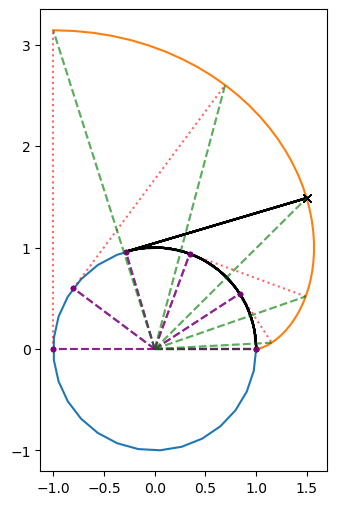

In [41]:
ax0.plot([np.cos(pltPts[phi][29]), pltPts[x][29]],
           [np.sin(pltPts[phi][29]), pltPts[y][29]],
           color = 'black')
ax0.plot(pltPts[x][29], pltPts[y][29], color = 'black', marker = "x")
ax0.plot(np.cos(pltPts.loc[0:29][phi]), np.sin(pltPts.loc[0:29][phi]), color = 'black')

resolution = 6
i = 0
invAng = np.zeros(resolution, dtype=complex)
wrapAng = np.zeros(resolution, dtype=complex)

for p in np.floor(np.linspace(0, len(pltPts) - 1, resolution)):
    invAng[i] = complex(pltPts.loc[p][x],  pltPts.loc[p][y])
    #display(np.real(invAng[i]))
    ax0.plot([0, np.real(invAng[i])], #pltPts.loc[p][x]],
           [0, np.imag(invAng[i])], #pltPts.loc[p][y]],
           color = 'green', alpha = .4, linestyle = "dashed")
    wrapAng[i] = 1 * np.exp(1j * pltPts.loc[p][phi])    
    ax0.plot([0, np.real(wrapAng[i])], #np.cos(pltPts.loc[p][phi])],
            [0, np.imag(wrapAng[i])], #np.sin(pltPts.loc[p][phi])],
            color = "purple", alpha = .4, linestyle = "dashed")
    ax0.plot(np.cos(pltPts.loc[p][phi]),
            np.sin(pltPts.loc[p][phi]),
            marker = ".", alpha = .8, color = "purple")
    i += 1
    
    
fig0

In [44]:
np.angle(wrapAng) - np.angle(invAng)

array([0.        , 0.52335646, 0.88343811, 1.07734161, 1.19035219,
       1.26262726])

## The Pressure Angle

The angle $\Theta$ can be defined as the result of the **Involute Function** $inv(\alpha)$. This forms the basis of the second, strictly angular interpretation of the involute curve, which is most commonly used for applications.

The involute function can be expressed shortly as:

$\Theta = inv(\alpha) = tan(\alpha) - \alpha$

Alternatively, it may also be expressed in terms of the roll angle,

$\Theta = \phi - \alpha$

From this, one finds that the roll angle $\phi = tan(\alpha)$.

$\alpha$ is the **Pressure Angle** of the involute curve. 

Should the involute curve be contacted by a plane (or really, any opposing curve) at the given point, the pressure angle $\alpha$ is the angle of a vector perpendicular (or normal, in 3D) to the curve faces, as measured from a radius line running from the center of the base circle -- this radius line, measured from the start of the involute curve, being $\Theta$!

In [22]:
Theta, alpha = s.symbols("\\Theta \\alpha")
pltPts = pltPts.join(pd.DataFrame({Theta: [np.angle(complex(pltPts[x][i],pltPts[y][i])) for i in range(len(pltPts))]}))

pltPts = pltPts.join(pd.DataFrame({alpha: pltPts[phi][::-1] - pltPts[Theta][::-1]}))

[]

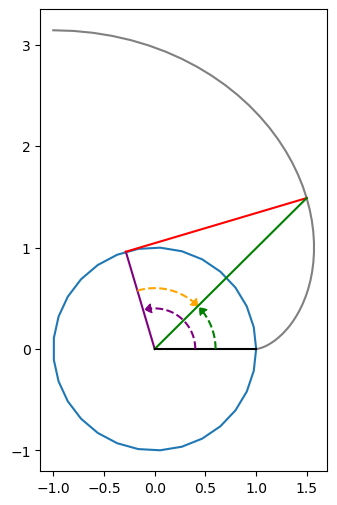

In [ ]:
fig1, ax1 = plt.subplots(figsize = (6,6))
ax1.plot(np.cos(np.linspace(0, np.pi * 2, 30)), np.sin(np.linspace(0, np.pi * 2, 30)))
ax1.plot(pltPts[x].to_list(), pltPts[y].to_list(), color = 'grey')
ax1.plot([0, np.cos(pltPts.iloc[29][phi])],
         [0, np.sin(pltPts.iloc[29][phi])],
         color = 'purple')
ax1.plot([np.cos(pltPts.iloc[29][phi]), Involute[x].subs({phi: pltPts.iloc[29][phi]})],
         [np.sin(pltPts.iloc[29][phi]), Involute[y].subs({phi: pltPts.iloc[29][phi]})],
         color = 'red')
ax1.plot([0, Involute[x].subs({phi: pltPts.iloc[29][phi]})],
         [0, Involute[y].subs({phi: pltPts.iloc[29][phi]})],
         color = 'green')
ax1.plot([0, 1],
         [0, 0],
         color = 'black')

arcDim_phi = pd.DataFrame({x: .4 * np.cos(pltPts.iloc[0:29][phi]), y:.4 * np.sin(pltPts.iloc[0:29][phi])})
ax1.plot(arcDim_phi[x], arcDim_phi[y], color = "purple", linestyle = "dashed")
# https://stackoverflow.com/a/43611169
posA, posB = zip(arcDim_phi[x][-2:].to_list(), arcDim_phi[y][-2:].to_list())
arcDim_phi_arrow = fArrow(posA = posA, posB = posB, 
                          arrowstyle= "fancy,head_length={},head_width={},tail_width={}".format(2*2, 3*2, 2),
                          color = "purple") 
ax1.add_artist(arcDim_phi_arrow)

arcDim_Theta = pd.DataFrame({x: .6 * np.cos(pltPts.iloc[0:29][Theta]), y:.6 * np.sin(pltPts.iloc[0:29][Theta])})
ax1.plot(arcDim_Theta[x], arcDim_Theta[y], color = "green", linestyle = "dashed")
# https://stackoverflow.com/a/43611169
posA, posB = zip(arcDim_Theta[x][-2:].to_list(), arcDim_Theta[y][-2:].to_list())
arcDim_Theta_arrow = fArrow(posA = posA, posB = posB, 
                          arrowstyle= "fancy,head_length={},head_width={},tail_width={}".format(2*2, 3*2, 2),
                          color = "green") 
ax1.add_artist(arcDim_Theta_arrow)

#arcDim_alpha = pd.DataFrame({x: .6 * (np.cos(pltPts[phi][0:30][::-1] - pltPts[Theta][0:30][::-1] + pltPts[Theta][29])), 
#                            y: .6 * (np.sin(pltPts[phi][0:30][::-1] - pltPts[Theta][0:30][::-1] + pltPts[Theta][29]))})
arcDim_alpha = pd.DataFrame({x: .6 * np.cos(pltPts[phi][29] - pltPts[alpha][0:29]),
                             y: .6 * np.sin(pltPts[phi][29] - pltPts[alpha][0:29])})
ax1.plot(arcDim_alpha[x], arcDim_alpha[y], color = "orange", linestyle = "dashed")
# https://stackoverflow.com/a/43611169
posA, posB = zip(arcDim_alpha[x][-2:].to_list(), arcDim_alpha[y][-2:].to_list())
arcDim_alpha_arrow = fArrow(posA = posA, posB = posB, 
                         arrowstyle= "fancy,head_length={},head_width={},tail_width={}".format(2*2, 3*2, 2),
                          color = "orange") 
ax1.add_artist(arcDim_alpha_arrow)

ax1.set_aspect('equal')
ax1.plot()


The pictured pressure angle $\alpha$ in orange is technically a 90-degree offset equivalent angle; one can imagine the as-defined orientation of the pressure angle as BETWEEN (1) a line perpendicular to the roll-angle tangent in red AT the involute contact point, and (2) an extension of the involute radius line in green.

## Interchange of Tangents and Parametric

To be able to work between both of these approaches is a conversion from angular to cartesian coordinates. 

The angle is known upfront, as the $\Theta$ angle in green. For the radius, the line in green, notice the right triangle formed by the base circle radius at the roll angle $\phi$ (purple) and the pressure angle line in red. With known angle $\alpha$ in orange, one could simply find this through the cosine with the purple radius. 

$R = \frac{D_{base}}{2} * \frac{1}{cos(\alpha)}$

Alternatively, the length in red is also known, as it is equal to the current arc length progress (roll angle) around the base circle.

$R^2 = \frac{D_{base}}{2}^2 + (\frac{D_{base}}{2} \times \phi)^2$

Either may be more convenient, depending on if $\alpha$ or $\phi$ is more readily available.

Carrying these forwards,

$x = \frac{D_{b} cos(\Theta)}{2cos(\alpha)} =   \frac{D_{b}}{2} cos(\Theta) \sqrt{1 + \phi^2}$

$y = \frac{D_{b} sin(\Theta)}{2cos(\alpha)} =   \frac{D_{b}}{2} sin(\Theta) \sqrt{1 + \phi^2}$

Confirming this visually:

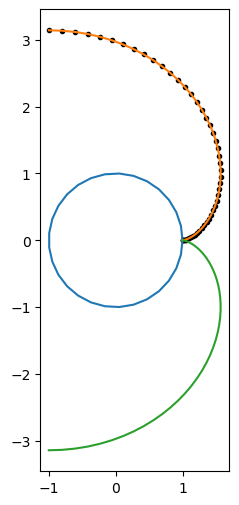

In [ ]:
fig2, ax2 = plt.subplots(figsize = (6,6))
ax2.plot(np.cos(np.linspace(0, np.pi * 2, 30)), np.sin(np.linspace(0, np.pi * 2, 30)))

ax2.scatter(x = pltPts[x],
            y = pltPts[y],
            marker = '.', color = 'black')
ax2.plot(np.sqrt(1 + pltPts[phi]**2) * np.cos(pltPts[Theta]),
         np.sqrt(1 + pltPts[phi]**2) * np.sin(pltPts[Theta]))
ax2.plot(1/np.cos(pltPts[alpha]) * np.cos(pltPts[Theta]),
         -1/np.cos(pltPts[alpha]) * np.sin(pltPts[Theta]))
ax2.set_aspect("equal")


## Functional Analysis

The involute function, mathematically, has some interesting behavior. See the below plot of the pressure angle over various roll angle values. Importantly is the asymptote at the 90-degree input value.

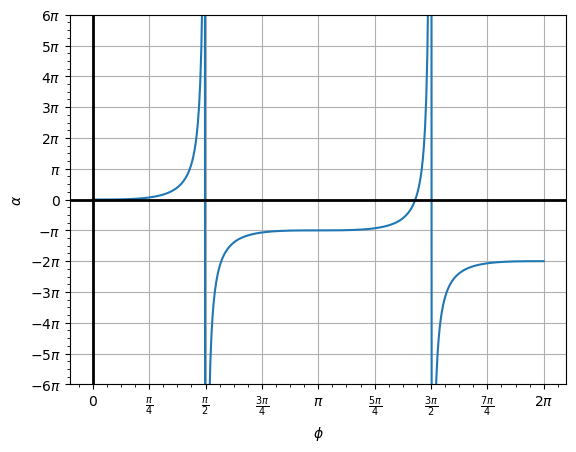

In [ ]:
# Showcase of involute function
x = s.symbols("x")
y = s.tan(x) - x 
y = s.lambdify(x, y)
x_val = np.linspace(0, np.pi*2, 400)
y_val = y(x_val)

plt.plot(x_val, y_val)
plt.ylim( (-np.pi * 6, np.pi * 6) )
plt.xlabel("$\\phi$")
plt.ylabel("$\\alpha$")
addPiSpacing(spacing=(4,1), gca= plt.gca(), axisDir="both")

## Footnotes

It is worth being wary that the above conversion scheme is only applicable to direct involute curves. Real-world gear profiles will, among many other modifications, almost always incorporate a profile shift (backlash) involving a rotation of the involute curve, which will necessarily require the equivalent transformation of the x y coordinates for accurate plotting.